# How to use Boltztrap2 pymatgen interface

Author: Francesco Ricci, UCLouvain, francesco.ricci@uclouvain.be, frankyricci@gmail.com

Warning: under development. Please if you find any bug or issues contact me.

Here you find how to use boltztrap2 directly through pymatgen.
Examples of what it is possible to do with it and which quantities can be computed from the band structure are provided.

Boltztrap2 needs to be installed.
Spin polarized is now implemented.

This notebook was tested with pymatgen == 2v2020.7.3. It should work with higher version too.

In [ ]:
# Uncomment the subsequent lines in this cell to install dependencies for Google Colab.
# !pip install pymatgen==2022.7.19

In [ ]:
import numpy as np
from monty.serialization import loadfn
from pymatgen.electronic_structure.boltztrap2 import (
    BandstructureLoader,
    BztInterpolator,
    BztPlotter,
    BztTransportProperties,
    Vasprun,
    VasprunBSLoader,
    VasprunLoader,
)

# Load DFT data

### Deprecated Loaders
Please, do not use them anymore. They will be removed any time soon.

In [ ]:
data = VasprunLoader().from_file("boltztrap2_data/vasprun-PbTe_uniform_bs.xml")

/home/tardo/github/matgenb/notebooks/boltztrap2.py:347: UserWarning: Deprecated Loader. Use VasprunBSLoader instead.
  warnings.warn("Deprecated Loader. Use VasprunBSLoader instead.")
/usr/lib64/python3.7/site-packages/pymatgen/io/vasp/outputs.py:886: UserWarning: No POTCAR file with matching TITEL fields was found in /home/tardo/github/matgenb/notebooks/boltztrap2_data
  " was found in {}".format(os.path.abspath(p)))


In [ ]:
bs = loadfn("boltztrap2_data/PbTe_bandstructure.json")
loader = BandstructureLoader(bs, data.structure)

/home/tardo/github/matgenb/notebooks/boltztrap2.py:220: UserWarning: Deprecated Loader. Use VasprunBSLoader instead.
  warnings.warn("Deprecated Loader. Use VasprunBSLoader instead.")


### New unique loader
You can load both vasprun or band structure pmg obj or directly from a vasprun.xml file.

In [ ]:
vrun = Vasprun(
    "boltztrap2_data/vasprun-PbTe_uniform_bs.xml", parse_projected_eigen=True
)
data = VasprunBSLoader(vrun)

In [ ]:
bs = vrun.get_band_structure()
nele = vrun.parameters["NELECT"]
st = vrun.final_structure
data = VasprunBSLoader(bs, structure=st, nelect=nele)

In [ ]:
data = VasprunBSLoader.from_file("boltztrap2_data/vasprun-PbTe_uniform_bs.xml")

# Interpolator

In [ ]:
# set curvature=False to speed up in case you do not need effective mass or hall coeficients
bztInterp = BztInterpolator(data, lpfac=10, energy_range=1.5, curvature=True)

### Compute and plot the band structure on standard symmetry path

In [ ]:
sbs = bztInterp.get_band_structure()
list(sbs.bands.values())[0].shape

(6, 137)

In [ ]:
from pymatgen.electronic_structure.plotter import BSPlotter

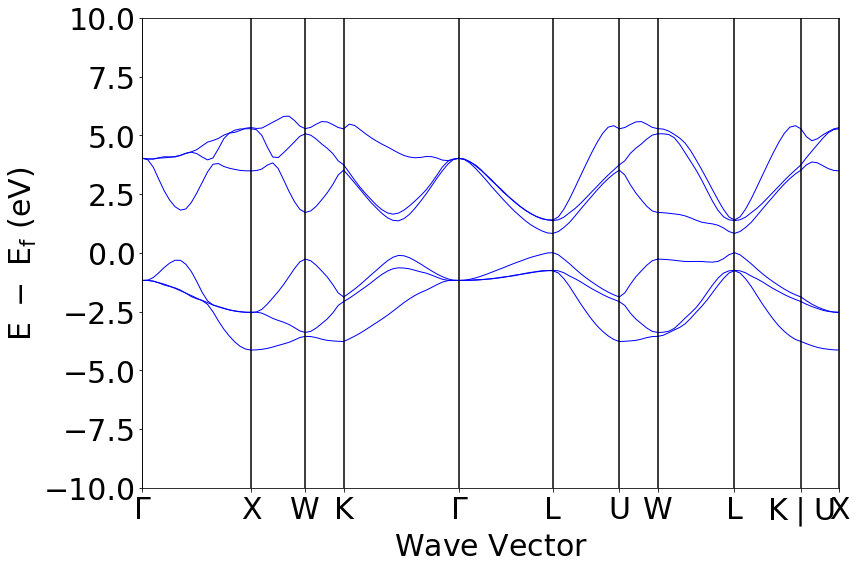

In [ ]:
BSPlotter(sbs).show()

### On a specific kpoint path

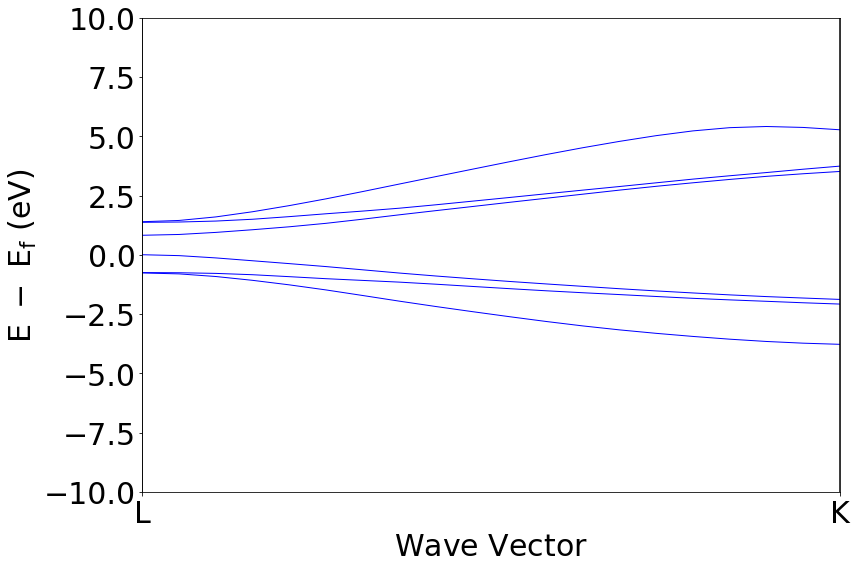

In [ ]:
# define the path as a list
kpaths = [["L", "K"]]
# set the fractional coordinates of the kpoint as a dict
kp_lbl = {"L": np.array([0.5, 0.5, 0.5]), "K": np.array([0.375, 0.375, 0.75])}
sbs = bztInterp.get_band_structure(kpaths, kp_lbl)
BSPlotter(sbs).show()

### Compute and plot Dos

In [ ]:
tot_dos = bztInterp.get_dos()
len(tot_dos.energies)

10000

In [ ]:
# set progress=True to show a progress bar
tot_proj_dos = bztInterp.get_dos(partial_dos=True, progress=False)

In [ ]:
len(tot_proj_dos.get_spd_dos().values())

3

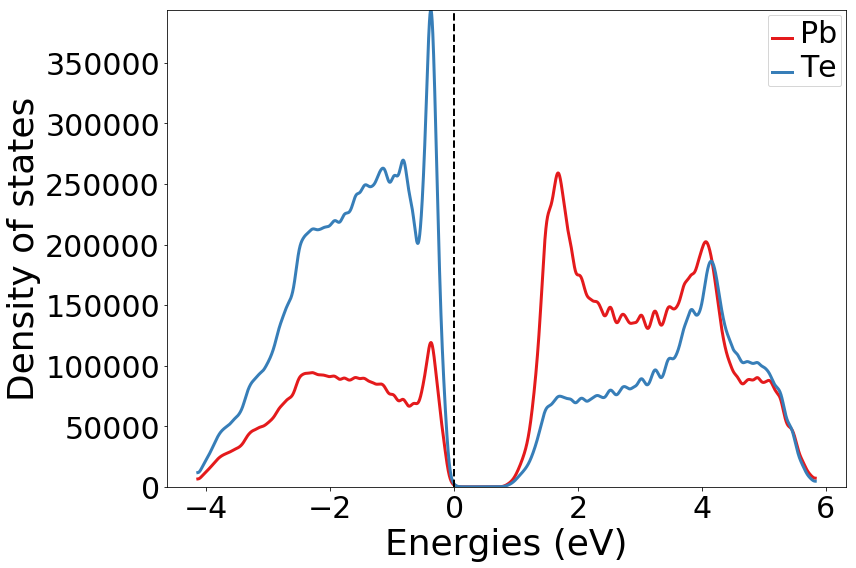

In [ ]:
from pymatgen.electronic_structure.plotter import DosPlotter

pltdos = DosPlotter(sigma=0.05)
pltdos.add_dos_dict(tot_proj_dos.get_element_dos())
pltdos.show()

### Save and Load coefficients
To save time in large systems, the coefficient of the interpolation can be saved in a file and read them later to avoid to recalculate them.

In [ ]:
# set fname argument to specify a different file name
bztInterp = BztInterpolator(
    data,
    lpfac=10,
    energy_range=1.5,
    curvature=True,
    save_bztInterp=True,
    fname="bztInterp.json.gz",
)
len(bztInterp.coeffs)

6

In [ ]:
bztInterp = BztInterpolator(data, load_bztInterp=True, fname="bztInterp.json.gz")
len(bztInterp.coeffs)

6

# Transport Properties

### Only w.r.t. the chemical potential

In [ ]:
bztTransp = BztTransportProperties(bztInterp, temp_r=np.arange(300, 1300, 300))

In [ ]:
print("\t".join(["Temp", r"\mu", "rows", "columns tensor"]))
for p in (
    bztTransp.Conductivity_mu,
    bztTransp.Seebeck_mu,
    bztTransp.Kappa_mu,
    bztTransp.Effective_mass_mu,
    bztTransp.Power_Factor_mu,
    bztTransp.Carrier_conc_mu,
):
    print("\t".join([str(i) for i in p.shape]))

Temp	\mu	rows	columns tensor
4	3252	3	3
4	3252	3	3
4	3252	3	3
4	3252	3	3
4	3252	3	3
4	3252


### Compute them w.r.t. specific doping levels

In [ ]:
bztTransp.compute_properties_doping(doping=10.0 ** np.arange(16, 23))

In [ ]:
print("\t".join(["Temp", "Doping", "rows", "columns tensor"]))
for p in (
    bztTransp.Conductivity_doping,
    bztTransp.Seebeck_doping,
    bztTransp.Kappa_doping,
    bztTransp.Carriers_conc_doping,
    bztTransp.Effective_mass_doping,
    bztTransp.Power_Factor_doping,
):
    print("\t".join([str(i) for i in p["n"].shape]))

Temp	Doping	rows	columns tensor
4	7	3	3
4	7	3	3
4	7	3	3
4	7
4	7	3	3
4	7	3	3


### Compute both together

In [ ]:
bztTransp = BztTransportProperties(
    bztInterp, temp_r=np.arange(300, 1300, 300), doping=10.0 ** np.arange(16, 23)
)

### Save and Load transport properties
The tranport properties can be saved into a file and loaded later.

In [ ]:
# set fname argument to specify a different file name
bztTransp = BztTransportProperties(
    bztInterp,
    temp_r=np.arange(300, 1300, 300),
    doping=10.0 ** np.arange(16, 23),
    save_bztTranspProps=True,
    fname="bztTranspProps.json.gz",
)

In [ ]:
bztTransp = BztTransportProperties(
    bztInterp, load_bztTranspProps=True, fname="bztTranspProps.json.gz"
)

# Plotter

In [ ]:
bztPlotter = BztPlotter(bztTransp, bztInterp)

<module 'matplotlib.pyplot' from '/usr/lib64/python3.7/site-packages/matplotlib/pyplot.py'>

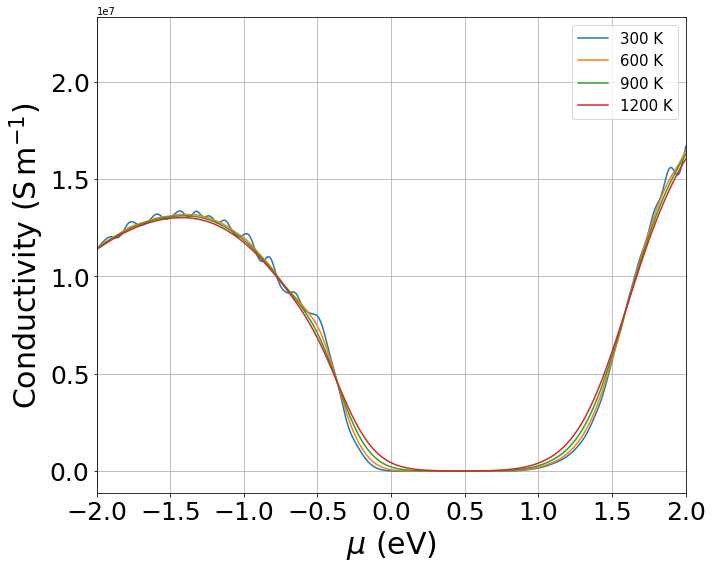

In [ ]:
bztPlotter.plot_props("C", "mu", "temp")

<module 'matplotlib.pyplot' from '/usr/lib64/python3.7/site-packages/matplotlib/pyplot.py'>

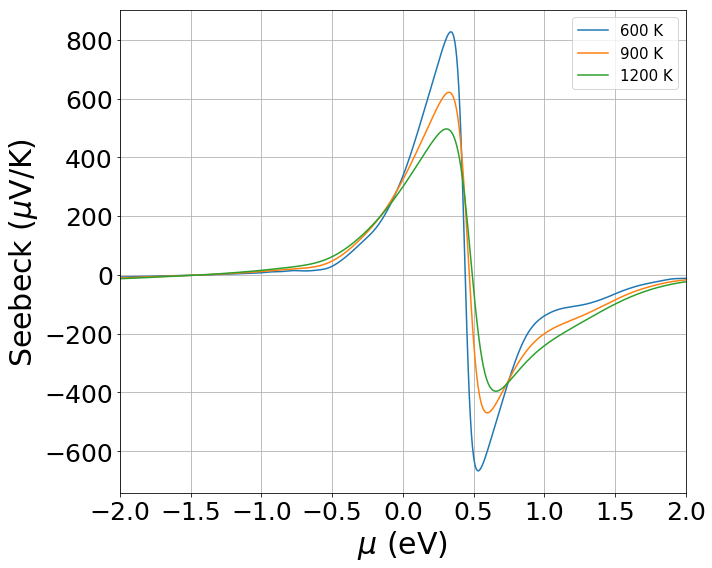

In [ ]:
bztPlotter.plot_props("S", "mu", "temp", temps=[600, 900, 1200])

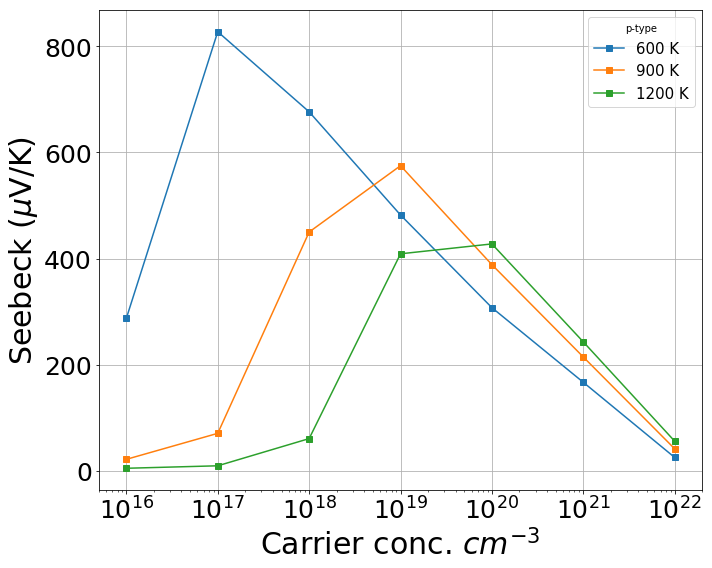

In [ ]:
bztPlotter.plot_props(
    "S", "doping", "temp", temps=[600, 900, 1200], dop_type="p"
).show()

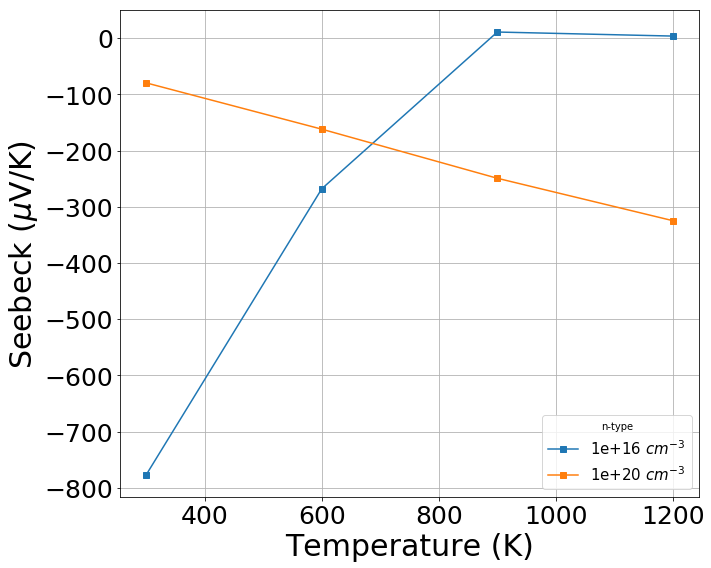

In [ ]:
bztPlotter.plot_props("S", "temp", "doping", doping=[1e16, 1e20], dop_type="n").show()

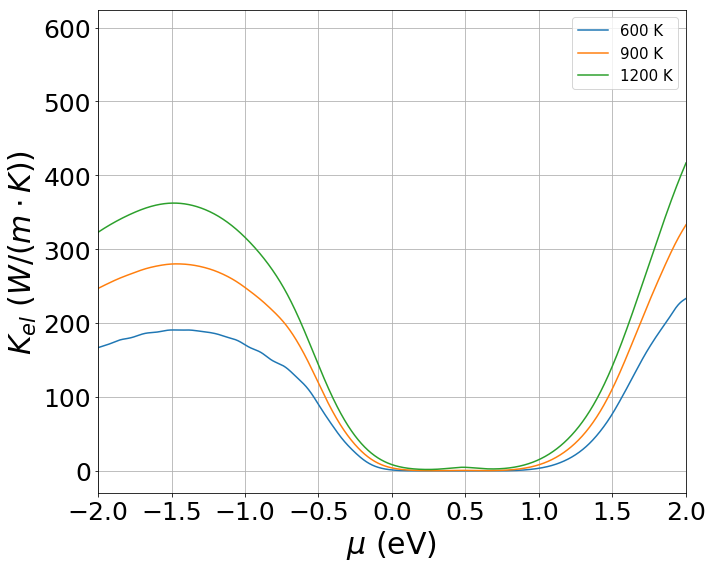

In [ ]:
bztPlotter.plot_props("K", "mu", "temp", temps=[600, 900, 1200]).show()

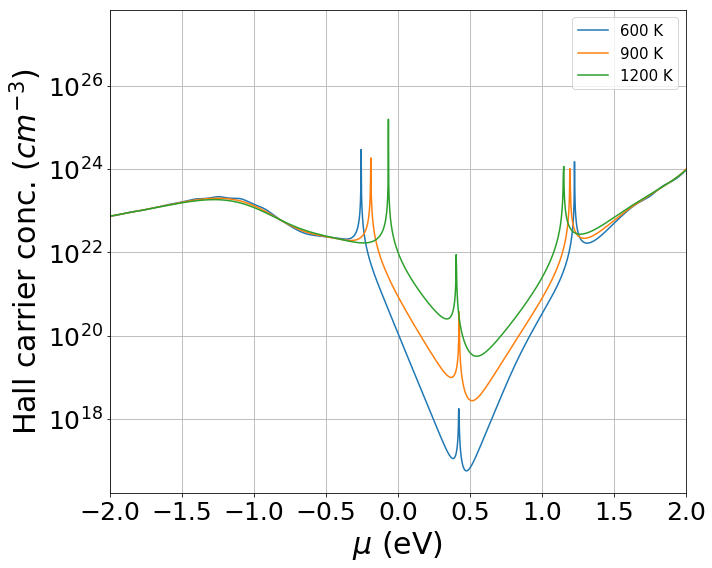

In [ ]:
bztPlotter.plot_props("H", "mu", "temp", temps=[600, 900, 1200]).show()

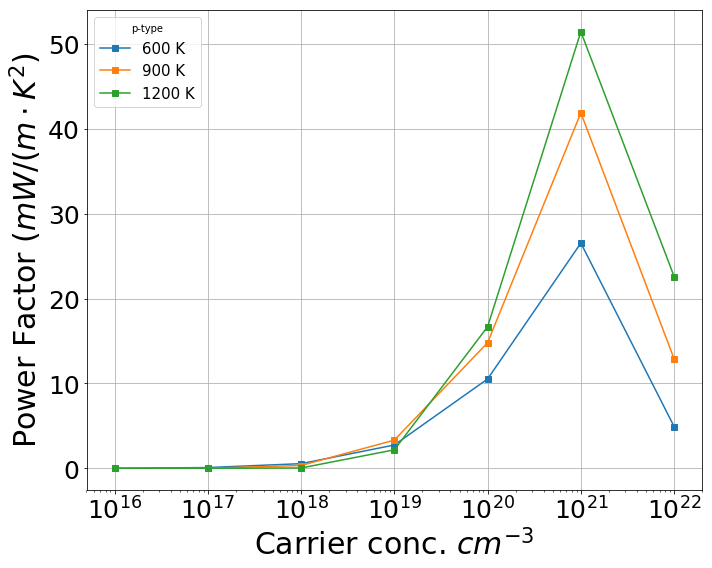

In [ ]:
bztPlotter.plot_props(
    "Po", "doping", "temp", temps=[600, 900, 1200], dop_type="p"
).show()

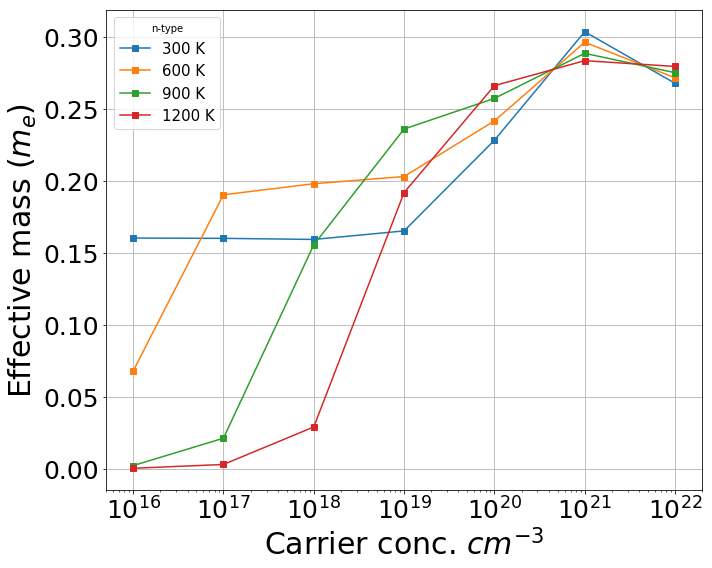

In [ ]:
bztPlotter.plot_props("E", "doping", "temp").show()

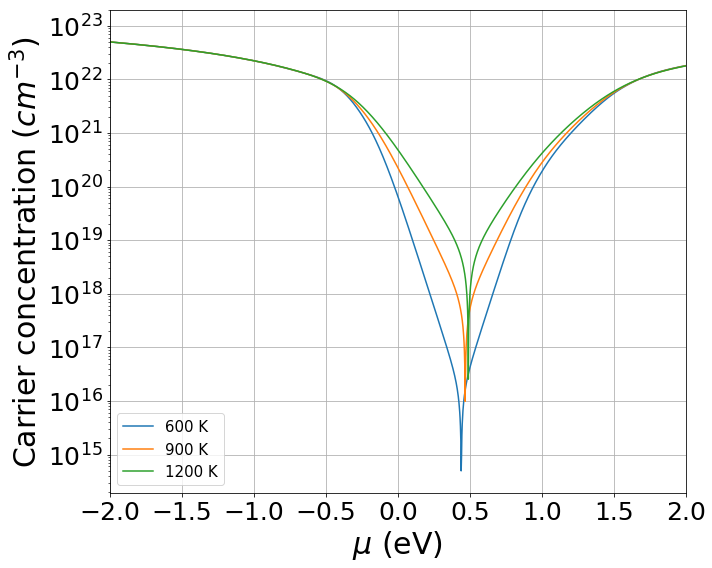

In [ ]:
bztPlotter.plot_props("Ca", "mu", "temp", temps=[600, 900, 1200]).show()

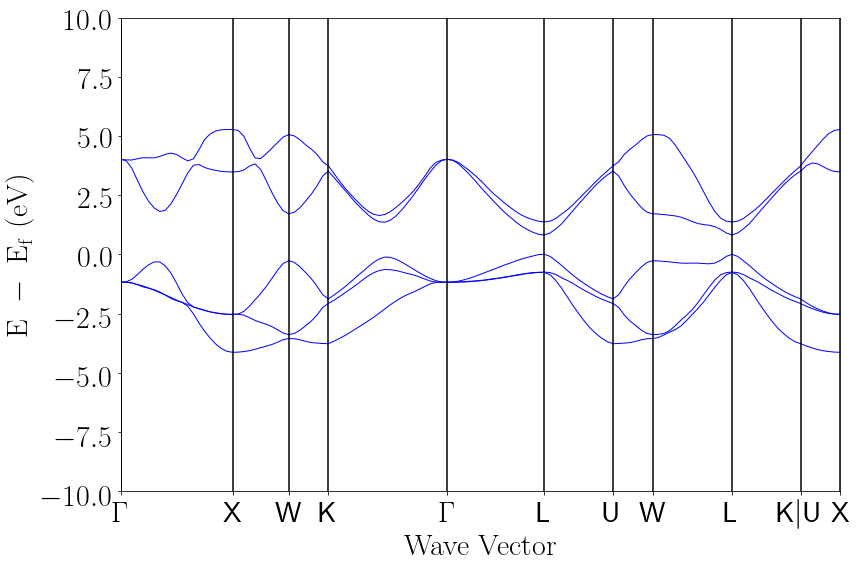

In [ ]:
bztPlotter.plot_bands().show()

10000


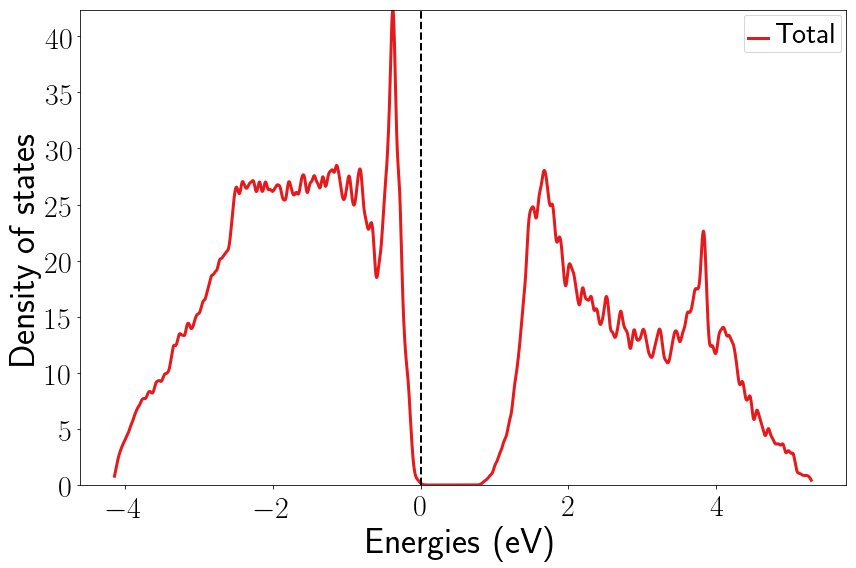

In [ ]:
bztPlotter.plot_dos(T=200).show()